# X-ray spectroscopies

*General aspects. In X-ray absorption spectroscopy the photon energy is tuned such that core electrons are targeted and excited to either bound or continuum states, and X-ray emission spectroscopy measures the subsequent decay from such an excited state. These core excitations/de-excitations exhibit strong relaxation effects, making theoretical considerations of the processes particularly challenging. While the removal of a valence electron leaves the remaining electrons relatively unaffected, removing core electrons has a substantial effect on the other electrons due to the significant change in the screening of the nucleus. Compare and contrast to UV/vis*

![X-ray processes considered](../img/xray/processes.svg)


- Figure: IP of elements (1s, 2s)?


**Not included (yet)**
- SO-coupling
- beyond electrinc-dipole approximation
- multireference methods

Loading modules, parameters, and broadening functions:

In [2]:
# loading QC software suites and functionalities
import veloxchem as vlx
from pyscf import gto, scf, mp, cc
import gator
import adcc
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection

# loading python 
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from scipy.interpolate import interp1d

# for vlx
from mpi4py import MPI
comm = MPI.COMM_WORLD
silent_ostream = vlx.OutputStream(None)

# conversion factors
au2ev = 27.211386

# broadening functions
def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)): yi[i] = yi[i] + y[k] * (gamma/2.) / ( (xi[i]-x[k])**2 + (gamma/2.)**2 )
    return xi,yi

def gaussian(x, y, xmin, xmax, xstep, sigma):
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(y)):
            yi[i] = yi[i] + y[k]*np.e**(-((xi[i]-x[k])**2)/(2*sigma**2))
    return xi,yi

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.


## X-ray photoemission spectroscopy

*We will here focus on calculating ionization potentials (IP:s), from which the isotropic photoemission spectrum is formed by giving each IP the same intensity and then broadening with a function. Can go beyond that using Dyson orbitals, but it doesn't make much of a difference...*

### From Koopmans' theorem

IP of gas phase water, using HF MO energies:

In [3]:
water = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# SCF calculation
molecule = vlx.Molecule.read_str(water, units='angstrom')
basis    = vlx.MolecularBasis.read(molecule, "6-31G")
scf_drv  = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_drv.compute(molecule, basis)

# Extract orbital energies
orbital_energies = scf_drv.scf_tensors['E']
print('1s IP from the Koopmans theorem:',np.around(au2ev*orbital_energies[0],3))

1s IP from the Koopmans theorem: -559.501


This is to be compared to the experimental value, which is 539.9 eV. The overestimation of almost 20 eV is due to lack of **relaxation**, which results from the reorganization of the valence electrons in response to a reduction of screening of the nuclei. An approach for including these effects in IP calculation is to use the $\Delta$SCF approach, in which the difference in total energy between the neutral and a core-hole system is considered as the IP.

### Maximum overlap method (MOM)

Eigenvalue equation

\begin{equation}
\textbf{FC}^{\textrm{new}} = 
\textbf{SC}^{\textrm{new}} \epsilon
\end{equation}

Chose to overlap the most with the span

\begin{equation}
\textbf{O} = 
\left( \textbf{C} \right)^{\dagger} \textbf{SC}^{\textrm{new}}
\end{equation}


Note potential instabilities for post-HF on core-hole (and excited states as well).

```{note}
We currently use `pyscf` for the illustrations involving core-holes, as VeloxChem lacks MOM (for now).
```

### From total energy differences

In [5]:
# Build mol-object and perform ground state SCF
mol = gto.Mole()
mol.atom  = water; mol.basis = '6-31G'
mol.build()
scf_res = scf.UHF(mol)
scf_res.kernel()

# Copy wave function information and change occupancy of alpha1 to 0
mo0  = copy.deepcopy(scf_res.mo_coeff)
occ0 = copy.deepcopy(scf_res.mo_occ)
occ0[0][0] = 0.0

# Perform wave function calculation with MOM restriction
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# IP from energy difference
print('Ionization potential:',np.around(au2ev*(scf_ion.energy_tot() - scf_res.energy_tot()),3),'eV')

converged SCF energy = -75.9838703827193  <S^2> = 6.3353767e-12  2S+1 = 1
converged SCF energy = -56.0754789470864  <S^2> = 0.76257805  2S+1 = 2.0125387
Ionization potential: 541.735 eV


Overwritten attributes  get_occ  of <class 'pyscf.scf.uhf.UHF'>


This estimate is now within 2 eV from experiment, and we can include correlation through MP2:

In [113]:
# Run MP2 on neutral and core-hole wave functions
mp_res = mp.MP2(scf_res).run()
mp_ion = mp.MP2(scf_ion).run()

# IP from energy difference
print('Ionization potential:',np.around(au2ev*(mp_ion.e_tot - mp_res.e_tot),3),'eV')

E(UMP2) = -76.1130483955489  E_corr = -0.129178012829717
E(UMP2) = -56.1523709631034  E_corr = -0.0768920160169649
Ionization potential: 543.158 eV


As well as use KS-DFT:

In [114]:
# SCF calculation with unrestricted KS-DFT
dft_res    = scf.UKS(mol)
dft_res.xc = 'b3lyp'
dft_res.kernel()

# Create core-hole in alpha1
mo0  = copy.deepcopy(dft_res.mo_coeff)
occ0 = copy.deepcopy(dft_res.mo_occ)
occ0[0][0] = 0.0

# SCF with core-hole
dft_ion = scf.UKS(mol); dft_ion.xc = 'b3lyp'
scf.addons.mom_occ(dft_ion, mo0, occ0)
dft_ion.kernel()

# IP from difference
print('Ionization potential:',np.around(au2ev*(dft_ion.energy_tot() - dft_res.energy_tot()),3),'eV')

converged SCF energy = -76.3480474320839  <S^2> = 2.5509372e-11  2S+1 = 1
converged SCF energy = -56.412542119436  <S^2> = 0.75441021  2S+1 = 2.0044054
Ionization potential: 542.473 eV


MP2 and DFT currently brings us **away** from experiment, but we note that the basis set is small and ill suited for core properties, and relativistic effects are not included either (more on this below). Using a cc-pCVTZ basis we instead obtain:
- HF: 538.929 eV
- MP2: 540.257 eV
- B3LYP: 539.192 eV

*i.e.* closer to experiment for the correlated methods (note that scalar-relativistic effects will shift these results upwards by $\sim$0.3 eV).

### XPS of the ESCA molecule

converged SCF energy = -407.075332882537  <S^2> = 1.2292076e-06  2S+1 = 1.0000025


Overwritten attributes  get_occ  of <class 'pyscf.scf.uhf.UHF'>


converged SCF energy = -396.183354220842  <S^2> = 0.84555897  2S+1 = 2.0933791
converged SCF energy = -396.245415504633  <S^2> = 0.76427602  2S+1 = 2.0142254
SCF not converged.
SCF energy = -396.32893797037 after 50 cycles  <S^2> = 0.99583161  2S+1 = 2.2323365
converged SCF energy = -396.439776971732  <S^2> = 0.76032128  2S+1 = 2.0102948


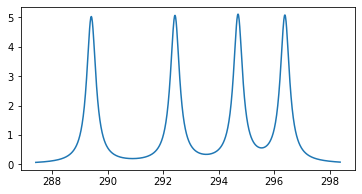

In [4]:
uracil   = ' C     0.000000     0.313341     1.284889;\
             C     0.000000    -1.129946     1.193271;\
             C     0.000000    -1.722413    -0.011510;\
             N     0.000000    -1.002386    -1.171240;\
             C     0.000000     0.377102    -1.212137;\
             N     0.000000     0.946281     0.038980;\
             O     0.000000     0.966706     2.309430;\
             O     0.000000     1.007669    -2.246643;\
             H     0.000000    -2.791379    -0.129000;\
             H     0.000000     1.954858     0.054525;\
             H     0.000000    -1.456186    -2.067038;\
             H     0.000000    -1.702677     2.098114'

# Create mol-object and perform neutral SCF calculation
mol_ura = gto.Mole()
mol_ura.atom  = uracil; mol_ura.basis = 'STO-3G'
mol_ura.build()
scf_ura = scf.UHF(mol_ura)
scf_ura.kernel()

# Perform core-hole calculation for each carbon atom (MOs 4-7) and append SCF IPs to a list
esca_ips = []
for i_mo in [4,5,6,7]:
    mo0 = copy.deepcopy(scf_ura.mo_coeff)
    occ0 = copy.deepcopy(scf_ura.mo_occ)
    occ0[0][i_mo] = 0.0
    ion_tmp = scf.UHF(mol_ura)
    scf.addons.mom_occ(ion_tmp, mo0, occ0)
    ion_tmp.kernel()
    esca_ips.append(au2ev*(ion_tmp.energy_tot() - scf_ura.energy_tot()))
    
# Broaden with a Lorentzian and plot
plt.figure(figsize=(6,3))
x,y = esca_ips,np.ones((len(esca_ips)))
# Call Lorentzian broadening with x-data, y-data, lower x-lim, upper x-lim, xstep, and broadening gamma
xi,yi = lorentzian(x,y,min(x)-2,max(x)+2,0.01,0.4)
plt.plot(xi,yi); plt.show()

*Note some convergence issues, largely relating to the small basis set.*

We can also broaden with a Gaussian (note that FWHM$= \gamma = 2\sqrt{2\ln{2}} \sigma$):

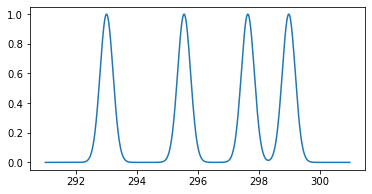

In [130]:
plt.figure(figsize=(6,3))
xi,yi = gaussian(x,y,min(x)-2,max(x)+2,0.01,0.5/(2*np.sqrt(2*np.log(2))))
plt.plot(xi,yi); plt.show()

Comparison to experiment using a cc-pCVTZ basis set:

![X-ray processes considered](../img/xray/esca_xps.svg)

Expt: O. Travnikovaa *et al., J. Elec. Spec. Rel. Phenom.* **185**, 191 (2012)

The features originate in, from low to high energy: -CH$_3$, -CH$_2$-, -CO-, and CF$_3$. We note a reasonable good agreement for the first two features, but the comparison is noticably worse for higher energies. This is likely an effect of the more significant change in electronic structure imposed by the very electronegative fluorine and oxygen atoms, which HF/cc-pCVTZ is not capable of describing properly.

## X-ray absorption spectroscopy

*Focus on NEXAFS, Core-excited states are embedded in a manifold of valence-excited states that needs to be considered by some computationally feasible method.*

![X-ray processes considered](../img/xray/nexafs.svg)

- Global spectrum

### CVS-ADC eigenstates

References to CVS approach and CVS error.

In [34]:
struct  = gator.get_molecule(water)
basis   = gator.get_molecular_basis(struct,'6-31G')
scf_res = gator.run_scf(struct,basis)
adc_res = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=6,core_orbitals=1)

SCF converged in 5 iterations.
Total Energy: -75.9838703827 au
                                                                                                                          
                                        Algebraic Diagrammatic Construction (ADC)                                         
                                                                                                                          
                               ADC method                   : cvs-adc2x                                                   
                               Number of Singlet States     : 6                                                           
                               CVS-ADC, Core Orbital Space  : 1                                                           
                               Convergence threshold        : 1.0e-06                                                     
                                                                            

/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        1.4139  291ms  [20.2703591  20.30081833 20.86977783 20.91121538 21.10647287 21.17210948]
  2    16       0.05362  600ms  [19.72495595 19.80691971 20.50881003 20.51569995 20.52445863 20.72564039]
  3    24      0.014469  700ms  [19.71673653 19.79707767 20.49577445 20.50503434 20.50804158 20.63850304]
  4    32      0.001267  833ms  [19.7163907  19.79671165 20.49373728 20.5048402  20.50629326 20.62964464]
  5    40    0.00011958   1.1s  [19.71637581 19.79669987 20.49353413 20.50482663 20.5061769  20.62883056]
=== Restart ===
  6    16    2.2907e-05  835ms  [19.7163753  19.79669916 20.49351327 20.5048247  20.50617017 20.62875659]
  7    24    8.2765e-06  842ms  [19.71637527 19.79669907 20.49350809 20.50482387 20.50616886 20.62873498]
  8    32    3.7389e-06   1.0s  [19.71637527 19.79669907 20.49350766 20.50482376 20.50616868 20.62872992]
  9    40     5.189e-07  959ms  [19.71637527 

+--------------------------------------------------------------+
| cvs-adc2x                               singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      19.71638      536.5099   0.0175    0.8001    0.1999  |
|  1       19.7967      538.6956   0.0368    0.8087    0.1913  |
|  2      20.49351      557.6567   0.0098    0.7858    0.2142  |
|  3      20.50482      557.9647   0.1007    0.8441    0.1559  |
|  4      20.50617      558.0013   0.0881     0.835     0.165  |
|  5      20.62873      561.3363   0.0104    0.7926    0.2074  |
+--------------------------------------------------------------+

Using inbuilt routines:


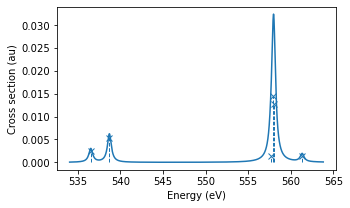

Or, constructing the spectra explicitly for the low-energy region:


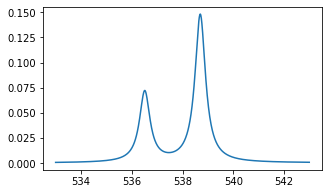

In [131]:
print(adc_res.describe())

print('Using inbuilt routines:')
plt.figure(figsize=(5,3))
adc_res.plot_spectrum()
plt.show()

print('Or, constructing the spectra explicitly for the low-energy region:')
plt.figure(figsize=(5,3))
x,y = au2ev*adc_res.excitation_energy, adc_res.oscillator_strength
xi,yi = lorentzian(x,y,533,543,0.01,0.5); plt.plot(xi,yi)
plt.show()

Compared to experiment with aug-cc-pCVTZ/cc-pVTZ (oxygen and hydrogen, respectively):

![X-ray processes considered](../img/xray/adc_water_xas.svg)

plt.figure(figsize=(5,4)); plt.subplot(211)
x,y = lorentzian(au2ev*adc_res.excitation_energy,adc_res.oscillator_strength,530,545,0.01,0.6)
plt.plot(x,y); plt.xlim((531,539)); plt.yticks([]); plt.legend(('CVS-ADC(2)-x',''))
plt.subplot(212)
data = np.loadtxt('../img/xray/water_xas.dat'); x,y = [],[]
for data_tmp in data: x.append(data_tmp[0]), y.append(data_tmp[1])
plt.plot(x,y); plt.xlim((531,539)); plt.yticks([]); plt.legend(('Experiment',''))
plt.show()

### TDDFT eigenstates

SIE discussion below

### TDDFT damped response function

In [51]:

molecule = vlx.Molecule.read_str(water, units='angstrom')
basis    = vlx.MolecularBasis.read(molecule, "6-31G")
scf_drv = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings  = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'b3lyp', 'grid_level': 4}
scf_drv.update_settings(scf_settings,method_settings); scf_drv.compute(molecule, basis)
freqs = np.arange(514.0,525.0,0.1)/au2ev; freqs_str = [str(x) for x in freqs]
cpp_prop = LinearAbsorptionCrossSection({'frequencies': ','.join(freqs_str), 'damping': 0.3/au2ev}
                                         ,method_settings)
cpp_prop.init_driver(comm, ostream=silent_ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)
sigma = []
for w in freqs:
    axx = -cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = -cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = -cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0; sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)

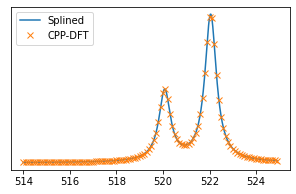

In [52]:
plt.figure(figsize=(5,3))
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
y = interp1d(au2ev*freqs, sigma, kind='cubic')
plt.plot(x,y(x));plt.plot(au2ev*freqs,sigma,'x')
plt.yticks([]); plt.legend(('Splined','CPP-DFT'))
plt.show()

Using aug-cc-pCVTZ and compared to experiment

![X-ray processes considered](../img/xray/tddft_water_xas.svg)

plt.figure(figsize=(5,4)); plt.subplot(211)
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
y = interp1d(au2ev*freqs, sigma, kind='cubic')
plt.plot(x,y(x));plt.plot(au2ev*freqs,sigma,'x')
plt.xlim((516,524)); plt.yticks([]); plt.legend(('Splined','CPP-DFT'))
plt.subplot(212)
data = np.loadtxt('../img/xray/water_xas.dat'); x,y = [],[]
for data_tmp in data: x.append(data_tmp[0]), y.append(data_tmp[1])
plt.plot(x,y); plt.xlim((531,539)); plt.yticks([]); plt.legend(('Experiment',''))
plt.show()

### Analysis

Vinylfluoride. CVS-ADC and CPP-DFT.

In [5]:
vinyl   = """
 C     0.000000    -0.246412    -1.271068
 C     0.000000     0.457081    -0.154735
 F     0.000000    -0.119195     1.052878
 H     0.000000     0.272328    -2.210194
 H     0.000000    -1.319906    -1.249847
 H     0.000000     1.530323    -0.095954
"""

# SCF
struct  = gator.get_molecule(vinyl)
basis   = gator.get_molecular_basis(struct,'6-31G')
scf_res = gator.run_scf(struct,basis)

# CVS space with three lowest
adc_full = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=10,core_orbitals=[1,2,3])

# CVS space with CHF carbon
adc_chf  = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=5,core_orbitals=[2])

# CVS space with CH2_carbon
adc_ch2  = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=5,core_orbitals=[3])

SCF converged in 7 iterations.
Total Energy: -176.8261179747 au
                                                                                                                          
                                        Algebraic Diagrammatic Construction (ADC)                                         
                                                                                                                          
                               ADC method                   : cvs-adc2x                                                   
                               Number of Singlet States     : 10                                                          
                               CVS-ADC, Core Orbital Space  : 1 2 3                                                       
                               Convergence threshold        : 1.0e-06                                                     
                                                                           

/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    20        0.8829  653ms  [10.90469041 11.0127478  11.12186879 11.13574581 11.15427206 11.22366101
 11.28574919]
  2    40       0.10942   1.6s  [10.57182281 10.67941692 10.72935948 10.75067863 10.81315185 10.81361514
 10.84327132]
  3    60     0.0061126   1.7s  [10.5578186  10.63999606 10.70185717 10.72113068 10.76319355 10.78079685
 10.81308698]
  4    80    0.00093309   2.2s  [10.55663393 10.63712372 10.69959336 10.71942129 10.76026749 10.77786459
 10.81039397]
  5   100    0.00016546   2.7s  [10.55654762 10.63677678 10.69916376 10.71927028 10.7598804  10.77734398
 10.81003679]
=== Restart ===
  6    40    2.6486e-05   2.3s  [10.55654338 10.63675306 10.69912635 10.7192592  10.75984691 10.77729448
 10.81000554]
  7    60     7.338e-06   2.0s  [10.55654292 10.63675005 10.69911833 10.7192576  10.75983953 10.77728372
 10.8099998 ]
  8    80    1.5555e-06   2.2s  [10.55654289 10.63674972 10.

                                                                                                                          
                                        Algebraic Diagrammatic Construction (ADC)                                         
                                                                                                                          
                               ADC method                   : cvs-adc2x                                                   
                               Number of Singlet States     : 5                                                           
                               CVS-ADC, Core Orbital Space  : 3                                                           
                               Convergence threshold        : 1.0e-06                                                     
                                                                                                                          
Starting cvs-adc

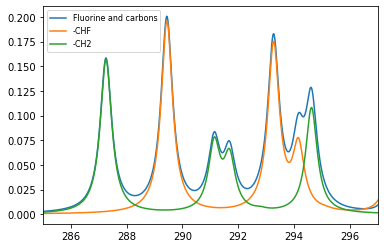

In [230]:
plt.figure(figsize=(6,4))
x,y = au2ev*adc_full.excitation_energy, adc_full.oscillator_strength
xi,yi = lorentzian(x,y,285,300,0.01,0.5); plt.plot(xi,yi)
x,y = au2ev*adc_chf.excitation_energy, adc_chf.oscillator_strength
xi,yi = lorentzian(x,y,285,300,0.01,0.5); plt.plot(xi,yi)
x,y = au2ev*adc_ch2.excitation_energy, adc_ch2.oscillator_strength
xi,yi = lorentzian(x,y,285,300,0.01,0.5); plt.plot(xi,yi)
plt.legend(('Fluorine and carbons','-CHF','-CH2'),loc='upper left',fontsize=8)
plt.xlim((285,297))
plt.show()

See that the results are identical between the CVS spaces.

Comparison to experiment using aug-cc-pCVTZ/cc-pVTZ:

![X-ray processes considered](../img/xray/adc_vinyl_xas.svg)


Discuss chemical shifts.

Now, lets look at various analysis tools.

Can study the amplitudes involved in adc calculations using the `state.describe_amplitudes` function, which takes as input `tolerance` which controls minimum amplitude to be printed, and the format using `index_format`, which takes three different forms. Splitting the resulting returning string according to `state` and printing the results for the first two states, we obtain:

In [48]:
print('From \'hf\' format, which yield MO number:')
des_amp    = adc_full.describe_amplitudes(tolerance=0.1,index_format='hf')
split_line = '\n\n'
tmp_amp    = des_amp.split(split_line)
print(tmp_amp[1])
print(tmp_amp[2])
print()

print('From \'adcc\' format, which indexing as used in adcc:')
des_amp    = adc_full.describe_amplitudes(tolerance=0.1,index_format='adcc')
split_line = '\n\n'
tmp_amp    = des_amp.split(split_line)
print(tmp_amp[1])
print(tmp_amp[2])
print()


print('From \'homolumo\' format, which using HOMO/LUMO/HOCO format:')
des_amp    = adc_full.describe_amplitudes(tolerance=0.1,index_format='homolumo')
split_line = '\n\n'
tmp_amp    = des_amp.split(split_line)
print(tmp_amp[1])
print(tmp_amp[2])

From 'hf' format, which yield MO number:
+---------------------------------------+
| State   1 ,      10.63675 au          |
+---------------------------------------+
|   1     ->  12      a ->a      -0.601 |
|   1     ->  22      a ->a      +0.105 |
|  11   1 ->  12  12  ab->ab     +0.149 |
+---------------------------------------+
| State   2 ,      10.69912 au          |
+---------------------------------------+
|   2     ->  13      a ->a        -0.5 |
|   2     ->  15      a ->a      +0.273 |
|   2     ->  14      a ->a       -0.22 |

From 'adcc' format, which indexing as used in adcc:
+-------------------------------------------------------+
| State   1 ,      10.63675 au,      289.4407 eV        |
+-------------------------------------------------------+
| (o2  1)         -> (v1  0)          a ->a      -0.601 |
| (o2  1)         -> (v1 10)          a ->a      +0.105 |
| (o1  8) (o2  1) -> (v1  0) (v1  0)  ab->ab     +0.149 |
+-----------------------------------------------------

We see that

- The first two states corresponds to transitions from two different MOs, which here corresponds to CHF and CH2

- The transitions are dominated to two different virtuals

Resolving core contributions using different eigenstates


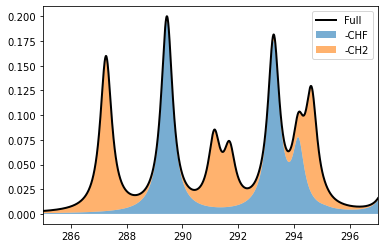

In [234]:
print('Resolving core contributions using different eigenstates')
plt.figure(figsize=(6,4))
x1,y1 = au2ev*adc_chf.excitation_energy, adc_chf.oscillator_strength
x1i,y1i = lorentzian(x1,y1,285,300,0.01,0.5)
x2,y2 = au2ev*adc_ch2.excitation_energy, adc_ch2.oscillator_strength
x2i,y2i = lorentzian(x2,y2,285,300,0.01,0.5)
plt.plot(x2i,y1i+y2i,'k-',linewidth=2.0)
plt.fill_between(x2i, 0, y1i,alpha=0.6)
plt.fill_between(x2i, y1i, y1i+y2i,alpha=0.6)
plt.legend(('Full','-CHF','-CH2'))
plt.xlim((285,297))
plt.show()

In [50]:



print('MAYBE: the same using the full-space eigenvectors')


print('Could come from looking more into the eigenstates, or by just splitting the describe_amplitude results...')

MAYBE: the same using the full-space eigenvectors
Could come from looking more into the eigenstates, or by just splitting the describe_amplitude results...


Polarization


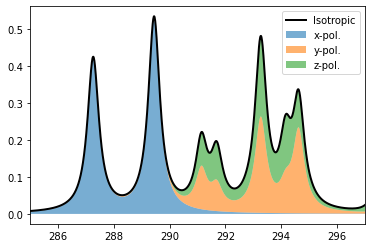

In [36]:
print('Polarization')
prefactor = 1.
sX,sY,sZ = [],[],[]
freq = adc_full.excitation_energy
for i in np.arange(len(freq)):
    tmp_tms = adc_full.transition_dipole_moment[i]
    sX.append(freqs[i]*tmp_tms[0]**2)
    sY.append(freqs[i]*tmp_tms[1]**2)
    sZ.append(freqs[i]*tmp_tms[2]**2)
    
plt.figure()
x,y = au2ev*freq, sX
xX,yX = lorentzian(x,y,285,300,0.01,0.5)
x,y = au2ev*freq, sY
xY,yY = lorentzian(x,y,285,300,0.01,0.5)
x,y = au2ev*freq, sZ
xZ,yZ = lorentzian(x,y,285,300,0.01,0.5)
plt.plot(xX,yX+yY+yZ,'k-',linewidth=2)
plt.fill_between(xX, 0, yX,alpha=0.6)
plt.fill_between(xX, yX, yX+yY,alpha=0.6)
plt.fill_between(xX, yX+yY, yX+yY+yZ,alpha=0.6)
plt.legend(('Isotropic','x-pol.','y-pol.','z-pol.'))
plt.xlim((285,297))
plt.show()

This can be done for CPP-DFT, taking the water calculation from above as an example.

Polarization:

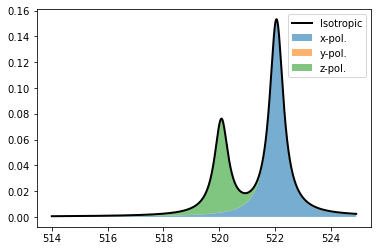

In [54]:
sX,sY,sZ = [],[],[]
for w in freqs:
    axx = -cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = -cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = -cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    sX.append(4.0 * np.pi * w * axx / 137.035999 / 3.0)
    sY.append(4.0 * np.pi * w * ayy / 137.035999 / 3.0)
    sZ.append(4.0 * np.pi * w * azz / 137.035999 / 3.0)

x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
yX = interp1d(au2ev*freqs, sX, kind='cubic')
yY = interp1d(au2ev*freqs, sY, kind='cubic')
yZ = interp1d(au2ev*freqs, sZ, kind='cubic')
plt.plot(x,yX(x)+yY(x)+yZ(x),'k-',linewidth=2)
plt.fill_between(x, 0, yX(x), alpha=0.6)
plt.fill_between(x, yX(x), yX(x)+yY(x), alpha=0.6)
plt.fill_between(x, yX(x)+yY(x), yX(x)+yY(x)+yZ(x), alpha=0.6)
plt.legend(('Isotropic','x-pol.','y-pol.','z-pol.'))
plt.show()

And atomic:

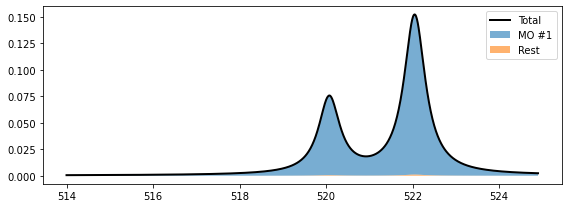

In [80]:
nocc = molecule.number_of_alpha_electrons()
nvirt = scf_drv.mol_orbs.number_mos() - nocc
spec_comp = []
solution_vecs = cpp_prop.get_property('solutions')
x_solution,y_solution,z_solution = [],[],[]
for w in freqs:
    x_solution.append(solution_vecs[('x',w)]); y_solution.append(solution_vecs[('y',w)]); z_solution.append(solution_vecs[('z',w)])
x_solution,x_solution,x_solution = np.array(x_solution),np.array(y_solution),np.array(z_solution)
for occ in np.arange(0,nocc): spec_comp.append([])
for i in np.arange(len(freqs)):
    x_tmp = x_solution[i]; y_tmp = y_solution[i]; z_tmp = z_solution[i]
    for occ in np.arange(0,nocc):
        comp_X = np.sum(np.abs(np.imag(x_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(x_tmp[:])))
        comp_Y = np.sum(np.abs(np.imag(y_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(y_tmp[:])))
        comp_Z = np.sum(np.abs(np.imag(z_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(z_tmp[:])))
        spec_comp[occ].append((comp_X*sX[i]+comp_Y*sY[i]+comp_Z*sZ[i]))
plt.figure(figsize=(8,3))
mo1     = np.array(spec_comp[0])
mo_rest = spec_comp[1]
for i in np.arange(2,len(spec_comp)):
    for j in np.arange(len(spec_comp[0])):
        mo_rest[j] += spec_comp[i][j]

        
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
y1    = interp1d(au2ev*freqs, mo1, kind='cubic')
yrest = interp1d(au2ev*freqs, mo_rest, kind='cubic')
plt.plot(x,y1(x)+yrest(x),'k-',linewidth=2)
plt.fill_between(x, yrest(x), y1(x)+yrest(x), alpha=0.6)
plt.fill_between(x, 0, yrest(x), alpha=0.6)
plt.legend(('Total','MO #1','Rest'))
plt.tight_layout()

...which is of course only one atom...

The decomposition for vinylfluoride yields

One figure - ADC and TDDFT, atomic and polarization

![X-ray processes considered](../img/xray/vinyl_decomp.svg)

Visualization and descriptors (?)

### Uracil in solution

CVS-ADC and CPP-DFT

1. Tailored CVS spaces

2. Gas phase

3. Polarizable embedding

### Maybe: massive system with DFT

## X-ray emission spectroscopy


- maybe illustration: Augen/fluorescent yield

### Decay from core-hole reference

Water (vs expt)

1. ADC(2)

2. TDDFT


In [47]:
mol = gto.Mole(); mol.atom  = water; mol.basis = '6-31G'; mol.build()
scfres = scf.UHF(mol); scfres.kernel()
mo0 = copy.deepcopy(scfres.mo_coeff); occ0 = copy.deepcopy(scfres.mo_occ); occ0[0][0] = 0.0
scfion = scf.UHF(mol); scf.addons.mom_occ(scfion, mo0, occ0); scfion.kernel()
adc_xes = adcc.adc2(scfion, n_states=4)

converged SCF energy = -75.9838703827193  <S^2> = 6.3389294e-12  2S+1 = 1
converged SCF energy = -56.0754789470864  <S^2> = 0.76257805  2S+1 = 2.0125387


/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8       0.77768   2.6s  [-19.29082067 -19.19940205 -18.96181907 -18.3637012 ]
  2    16     0.0010764  445ms  [-19.44427093 -19.36689642 -19.16826546 -18.57947501]
  3    24    4.4301e-07  450ms  [-19.44429764 -19.3669284  -19.16831914 -18.57954987]
=== Converged ===
    Number of matrix applies:    24
    Total solver time:             3s 527ms


Using inbuilt functionalities, noticing the negative energies


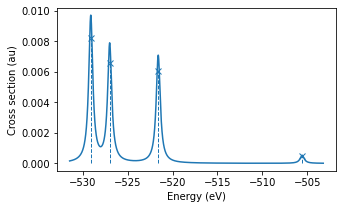

Flipping the x-axis and focusing on the high-energy features:


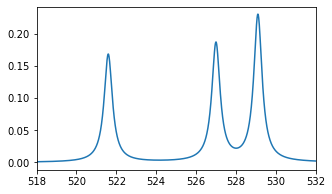

In [55]:
print('Using inbuilt functionalities, noticing the negative energies')

plt.figure(figsize=(5,3))
adc_xes.plot_spectrum()
plt.show()

print('Flipping the x-axis and focusing on the high-energy features:')

plt.figure(figsize=(5,3))
x,y = -au2ev*adc_xes.excitation_energy,adc_xes.oscillator_strength
xi,yi = lorentzian(x,y,min(x)-5,max(x)+5,0.01,0.5); plt.plot(xi,yi)
plt.xlim((518,532))
plt.show()

Using cc-pCVTZ and compared to experiment

![X-ray processes considered](../img/xray/adc_water_xes.svg)

plt.figure(figsize=(5,4)); plt.subplot(211)
x,y = -au2ev*adc_xes.excitation_energy,adc_xes.oscillator_strength
xi,yi = lorentzian(x,y,min(x)-5,max(x)+5,0.01,0.5); plt.plot(xi,yi)
plt.xlim((518,529)); plt.yticks([]); plt.legend(('ADC(2)',''))
plt.subplot(212)
data = np.loadtxt('../img/xray/water_xes.dat'); x,y = [],[]
for data_tmp in data: x.append(data_tmp[0]), y.append(data_tmp[1])
plt.plot(x,y); plt.xlim((518,529)); plt.yticks([]); plt.legend(('Experiment',''))
plt.show()

And for TDDFT

### Overlap model

Water (vs expt)

1. DFT

Energy from

\begin{equation}
\Delta E = \epsilon_v - \epsilon_c
\end{equation}


and intensities from

\begin{equation}
f \propto \left| \langle \phi_i \left| \hat{\mu} \right| \phi_c \rangle \right| ^2
\end{equation}

In [61]:
scf_drv = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings  = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'b3lyp', 'grid_level': 4}
scf_drv.update_settings(scf_settings,method_settings); scf_drv.compute(molecule, basis)
orbital_energies = scf_drv.scf_tensors['E']
nocc = molecule.number_of_alpha_electrons()
print('Occupied orbital energies:',au2ev*orbital_energies[:nocc])

core = 0
overlap_energy = []
for virt in np.arange(nocc):
    if virt != core:
        overlap_energy.append(au2ev*(orbital_energies[virt]-orbital_energies[core]))

Occupied orbital energies: [-520.65736958  -27.68790742  -14.39953656   -9.70378086   -7.94953419]


Focusing on high-energy features


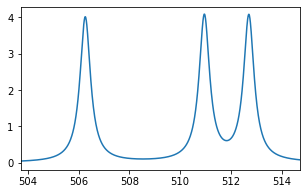

In [59]:
print('Focusing on high-energy features')

plt.figure(figsize=(5,3))
x,y = overlap_energy, np.ones((len(overlap_energy)))
xi,yi = lorentzian(x,y,min(x)-5,max(x)+5,0.01,0.5); plt.plot(xi,yi)
plt.xlim((max(overlap_energy)-9,max(overlap_energy)+2))
plt.show()

using cc-pCVTZ and compared to experiment

![X-ray processes considered](../img/xray/overlap_water_xes.svg)

plt.figure(figsize=(5,4)); plt.subplot(211)
x,y = overlap_energy, np.ones((len(overlap_energy)))
xi,yi = lorentzian(x,y,min(x)-5,max(x)+5,0.01,0.5); plt.plot(xi,yi)
plt.xlim((max(overlap_energy)-9,max(overlap_energy)+2)); plt.yticks([]); plt.legend(('DFT overlap',''))
plt.subplot(212)
data = np.loadtxt('../img/xray/water_xes.dat'); x,y = [],[]
for data_tmp in data: x.append(data_tmp[0]), y.append(data_tmp[1])
plt.plot(x,y); plt.xlim((518,529)); plt.yticks([]); plt.legend(('Experiment',''))
plt.show()

### Maybe: uracil in solution

1. Gas phase

2. Environment with PE

### Maybe valence-to-core XES

Suitable TM-complex with minimal static correlation

1. Overlap

2. TDDFT?

### Maybe: massive system with DFT

## Resonant inelastic X-ray scattering


Water.

1. 2-step model

2. DKH

## Coupling to molecular dynamics


Some system...

1. Dynamics + XAS

2. Dynamics + XES

3. Inclusion of environment?

4. Core-hole dynamics with some model?

## Self-interaction error in DFT

For a single-electron systems the following equality should hold for the two-electron terms:

$$
J[\rho] + E_{xc} [\rho] = 0.0
$$

This cancellation is achieved for, e.g. Hartree–Fock theory, but for any approximate functionals in DFT it will instead result in an erronous contribution to the energy. DFT-based methods generally suffer from self-interaction error (SIE), which corresponds to the sum of Coulomb and exchange self-interactions that remain because of the use of approximate exchange functionals. In more detail, the Coulomb self-repulsion of each electron included in the Coulomb operator is exactly canceled by the nonlocal exchange self-attraction in Hartree--Fock theory, but this is no longer the case when the exchange operator is replaced by an approximate exchange functional.

- Radial distribution or something for functionals? Calculate error?

## Relativity

1. Water IP without relativity or with X2C

2. Total relativistic and correlation corrections as a function of Z

## Relaxation

### In ADC


### In TDDFT


1. Radial distribution: Z, Z with hole, Z+1

2. Total density: formaldehyde

3. Maybe: visualization of effects for XAS and XES

![X-ray processes considered](../img/xray/relax_form.svg)

## Basis set considerations

The basis set requirements of X-ray spectrum calculations will depend strongly on which spectroscopy

- XPS and XES probes occupied states, and thus need a good description of those

- XAS and RIXS probes excited states, and thus need an improved description also of this region

However, in both cases the relaxation due to the creation of a core-hole need to be enabled, which yield requirements of reasonable flexibility of the core and inner valence region. This is not typically the case, as most studies deals with valence electron and thus have a minimal or close to minimal description of the core region.

A number of approaches for improving the basis sets have been developed:

1. Augment the Dunning basis sets with core-polarizing functions, e.g. cc-pV*n*Z $\rightarrow$ cc-pCV*n*Z

2. Adding extra flexibility by performing full or partial decontraction, e.g.
    1. u6-311++G** is 6-311++G** with decontracted 1s function of the probed element
    2. un-6-311++G** is a fully decontracted 6-311++G** basis set

3. Use basis functions from the next element, is inspired by the equvalent core/Z+1 approximation

Here we focus on the basis set effects for calculations of the IP of water, and we encourage the interested reader to do the same excercise for XES, as well as for XAS (where the augmentation of diffuse functions also need to be considered).

In [79]:
u6311gss  = {'O': gto.basis.parse('''
O    S
   8588.500                  1.000000 
O    S
   1297.230                  1.000000 
O    S
    299.2960                 1.000000 
O    S
     87.37710                1.000000 
O    S
     25.67890                1.000000 
O    S
      3.740040               1.000000 
O    SP
     42.11750                0.113889               0.0365114
      9.628370               0.920811               0.237153
      2.853320              -0.00327447             0.819702
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
'''), 'H': '6-311G**'}
un6311gss = {'O': gto.basis.parse('''
O    S
   8588.500                  1.000000 
O    S
   1297.230                  1.000000 
O    S
    299.2960                 1.000000 
O    S
     87.37710                1.000000 
O    S
     25.67890                1.000000 
O    S
      3.740040               1.000000 
O    SP
     42.11750                1.000000               1.000000
O    SP
      9.628370               1.000000               1.000000
O    SP
      2.853320               1.000000               1.000000
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
'''), 'H': '6-311G**'}
z6311gss  = {'O': gto.basis.parse('''
O    S
   8588.500                  0.00189515
   1297.230                  0.0143859
    299.2960                 0.0707320
     87.37710                0.2400010
     25.67890                0.5947970
      3.740040               0.2808020
O    SP
     42.11750                0.113889               0.0365114
      9.628370               0.920811               0.237153
      2.853320              -0.00327447             0.819702
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
O    S
  11427.10                   0.00180093
   1722.350                  0.0137419
    395.7460                 0.0681334
    115.1390                 0.2333250
     33.60260                0.5890860
      4.919010               0.2995050
O    SP
     55.44410                0.114536               0.0354609
     12.63230                0.920512               0.237451
      3.717560              -0.00337804             0.820458
O    SP
      1.165450               1.000000               1.000000
O    SP
      0.321892               1.000000               1.000000
O    D
      1.750                  1.000000
'''), 'H': '6-311G**'}

Exotic version of basis sets found above

```python
basis_sets = ['6-311G**',u6311gss,un6311gss,z6311gss, 'cc-pVDZ', 'cc-pCVDZ', 'cc-pVTZ', 'cc-pCVTZ','cc-pVQZ', 'cc-pCVQZ']
ip_hf, ip_mp2, ip_ccsd, ip_b3lyp, n_bas = [],[],[],[],[]
for basis in basis_sets:
    mol = gto.Mole(); mol.atom  = water; mol.basis = basis
    mol.build()
    scfres = scf.UHF(mol); scfres.kernel()
    mo0 = copy.deepcopy(scfres.mo_coeff); occ0 = copy.deepcopy(scfres.mo_occ); occ0[0][0] = 0.0
    scfion = scf.UHF(mol); scf.addons.mom_occ(scfion, mo0, occ0); scfion.kernel()
    ip_hf.append(au2ev*(scfion.energy_tot() - scfres.energy_tot()))
    ccsd_res = cc.UCCSD(scfres).run(); ccsd_ion = cc.UCCSD(scfion).run(max_cycle=500)
    ip_ccsd.append(au2ev*(ccsd_ion.e_tot - ccsd_res.e_tot))
    ip_mp2.append(au2ev*(ccsd_ion.e_hf+ccsd_ion.emp2-(ccsd_res.e_hf+ccsd_res.emp2)))
    scfres = scf.UKS(mol); scfres.xc = 'b3lyp'; scfres.kernel()
    mo0 = copy.deepcopy(scfres.mo_coeff); occ0 = copy.deepcopy(scfres.mo_occ); occ0[0][0] = 0.0
    scfion = scf.UKS(mol); scf.addons.mom_occ(scfion, mo0, occ0); scfion.xc = 'b3lyp'; scfion.kernel()
    ip_b3lyp.append(au2ev*(scfion.energy_tot() - scfres.energy_tot()))
    n_bas.append(len(scfres.mo_occ[0]))
    
plt.figure(figsize=(10,5))
basis_set_labels = ['6-311G**','u6-311G**','un6-311G**','6-311G** (Z+1)', 'cc-pVDZ', 'cc-pCVDZ', 'cc-pVTZ', 'cc-pCVTZ','cc-pVQZ', 'cc-pCVQZ']
plt.plot(n_bas,ip_hf,'r*'); plt.plot(n_bas,ip_mp2,'bv')
plt.plot(n_bas,ip_ccsd,'d',color='orange'); plt.plot(n_bas,ip_b3lyp,'go')
plt.plot([min(n_bas)-5,max(n_bas)+5],[539.9,539.9],'k:')
plt.plot([min(n_bas)-5,max(n_bas)+5],[539.9-0.3,539.9-0.3],'k--')
plt.xlim((min(n_bas)-5,max(n_bas)+5))
plt.ylabel('Ionization potential [eV]')
plt.legend(('HF','MP2','CCSD','B3LYP','Expt','Expt - 0.3 eV'))
plt.xticks(n_bas,basis_set_labels,rotation=70,fontsize=10)
plt.tight_layout(); plt.savefig('basis_xps.svg')
plt.show()
```

The execution of which yields


![X-ray processes considered](../img/xray/basis_xps.svg)

On the y-axis we see the basis set labels, with order and position determined by the number of basis functions.

We see that...